In [1]:
import pandas as pd
import numpy as np
import scipy.signal
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import itertools
import math
import statistics as sts
import gc as gc
import sys
from sklearn.preprocessing import StandardScaler

<h1>Script Generador de Features</h1>
<blockquote>
    <p>Este script genera las features que luego utilizaremos en el análisis univariado y multivariado.</p>
</blockquote>

In [2]:
##Definimos el orden de los atributos antes de codear de forma rapida
##Esta clase esta solo para asegurar ese orden.
class Sample():

    def __init__(self, featuresDict):
        self.features = {}

        for k,v in featuresDict.items():
            self.features[k] = v

    def show_features_as_np(self):
        valores = []
        for i, forma_de_calcular_feature in enumerate(['media_','std_']):
            for  j, tipo_de_banda in enumerate(['delta', 'theta', 'alpha', 'beta', 'gamma', 'delta_norm', 'theta_norm', 'alpha_norm', 'beta_norm', 'gamma_norm', 'intra', 'inter']):
                valores.append(self.features["{}{}".format(forma_de_calcular_feature,tipo_de_banda)])
                
        return np.array(valores)

In [3]:
#Calculo la potencia de cada banda
def calcular_potencia_por_bandas_de_frecuencias(f, P):
    return {
        'delta': P[f<4].sum(),
        'theta': P[(4<=f) & (f<8)].sum(),
        'alpha': P[(8<=f) & (f<13)].sum(),
        'beta' : P[(13<=f) & (f<30)].sum(),
        'gamma': P[30<=f].sum()
    }

#  Dado un diccionario con pontencia de cada banda, 
#      calculo la potencia normalizada de cada banda.
def normalizar_banda(bandas):
    suma_del_poder_total = sum(bandas.values()) 
    bandas_norm = {}

    for key, value in bandas.items():
        bandas_norm["{}_norm".format(key)]= bandas[key]/suma_del_poder_total

    return bandas_norm

def crear_sample_con_features(lista_de_marcadores_por_epoch):
    features_paciente = {}

    #Junto todos los valores de un mismo marcador para usar mean y stdev de statistics
    for key, value in lista_de_marcadores_por_epoch[0].items():
        
        _values = np.array([])
        
        for dic in lista_de_marcadores_por_epoch:
            _values = np.append(_values, dic[key])

        _mean = sts.mean(_values)
        _stdev = sts.stdev(_values,xbar=_mean)

        features_paciente["media_{}".format(key)] = _mean
        features_paciente["std_{}".format(key)] = _stdev

    return Sample(features_paciente)

# De cada muestra o sample tomamos 24 features ya elegidos, computados a través del promedio y varianza
#      entre los epochs de cada paciente.
def calcular_features_de_un_paciente(paciente):
    p_ = paciente.groupby(['epoch','tiempo']).mean()

    lista_de_epochs = list( set(p_.loc[:,:].index.get_level_values('epoch')) )
    lista_de_marcadores_por_epoch = []

    for epoch in lista_de_epochs:
        
        frecuencias = p_.loc[epoch,:]
        f, P = scipy.signal.welch(frecuencias['valores'], fs=250, nperseg=201)
        

        # Calculo todos los marcadores que necesito para un epoch
        # Estos son las bandas, las bandas normalizadas y alguna medida intra/inter electrodo
        marcadores_de_este_epoch = calcular_potencia_por_bandas_de_frecuencias(f,P)
        marcadores_de_este_epoch.update(normalizar_banda(marcadores_de_este_epoch))
        
        #TODO: Cambio de Intra Inter
        marcadores_de_este_epoch.update({"intra":np.random.rand(20,24), "inter":np.random.rand(20,24)})
        
        lista_de_marcadores_por_epoch.append( marcadores_de_este_epoch )

    return crear_sample_con_features(lista_de_marcadores_por_epoch)

#   Usamos los mismos archivos *.hdf generados para el TP anterior.
def levantar_hdf(load_name, nth):
    paciente = load_name + "{:02d}".format(i)
    return pd.read_hdf(load_path.format(paciente))

In [4]:
## Aprovechamos los .hdf generados a partir de los .mat en el tp anterior.
path = "../../tp2/datos/"
load_path = path + "/{}.hdf"

##Hay que preguntar si solo me interesan estos electrodos o todos
##Por ahora solo me quedo con los electrodos que me interesan
electrodos = [8, 44, 80, 131, 185]

N_P = 1
N_S = 1

N_P_samples = []
N_S_samples = []

for load_name, N, data_set ,offset in [("P", N_P, N_P_samples, 0), ("S", N_S, N_S_samples, 10)]:
    for i in range(1, 1 + N):
        sys.stdout.write("\r{}".format(i))
        sys.stdout.flush()
        df_ = levantar_hdf(load_name, i)
        df_ = df_.loc[offset + i-1,:,electrodos,:]
        
        data_set.append( calcular_features_de_un_paciente(df_) )

        gc.collect()

1

Miremos como están quedando los datos. Un buen grafico para ver que tan sparsos son los valores de cada feature estaría bueno.

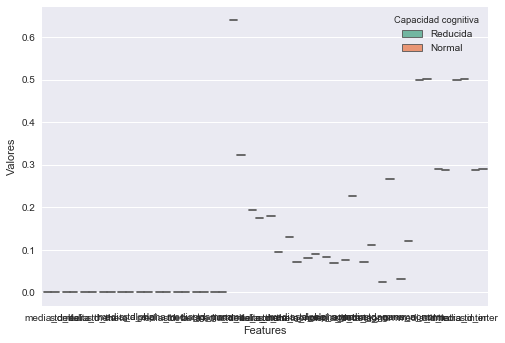

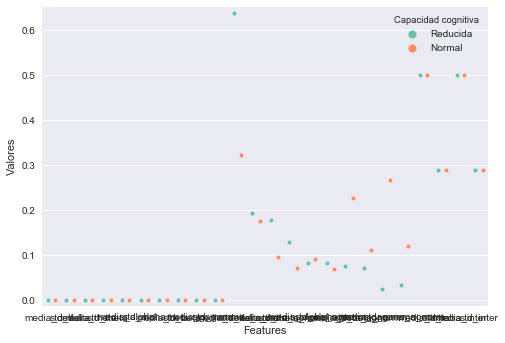

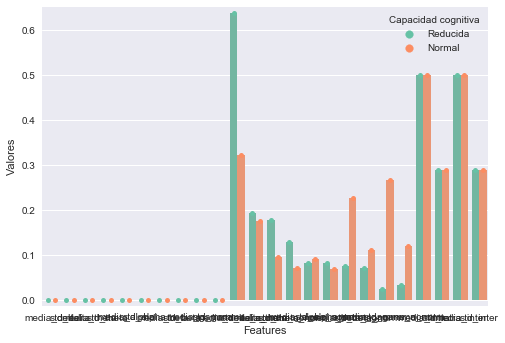

In [6]:
def analisis_comparativo(df_b):
    ymin = min(df_b['Valores'])
    ymax = max(df_b['Valores'])
    decimo = (ymax - ymin)/len(df_b['Valores'])
    ymin, ymax = ymin - decimo, ymax + decimo

    # Hay que tener en cuenta que son pocos valores

    ax = sns.violinplot(x="Features", y="Valores", hue="Capacidad cognitiva", data=df_b,  split=True, palette="Set2", inner="stick", cut=0)
    sns.plt.show()

    ax = sns.swarmplot(x="Features", y="Valores", hue="Capacidad cognitiva", data=df_b,  split=True, palette="Set2", size=4)
    ax.set_ylim([ymin, ymax])
    sns.plt.show()

    sns.barplot(x="Features", y="Valores", hue="Capacidad cognitiva", data=df_b, palette="Set2")
    ax = sns.swarmplot(x="Features", y="Valores", hue="Capacidad cognitiva", split=True, data=df_b, palette="Set2")
    ax.set_ylim([ymin, ymax])
    
    handles, labels = ax.get_legend_handles_labels()
    l = ax.legend(handles[:2], labels[:2])
    l.set_title("Capacidad cognitiva", prop = {'size':'small'})
    sns.plt.show() 



np_features_por_paciente = []

for muestra in N_P_samples + N_S_samples:
    np_features_por_paciente.append( muestra.show_features_as_np() )

df_features_compress = pd.DataFrame({
    "Capacidad cognitiva": (["Reducida"] * (N_P * 24)) + (["Normal"] * (N_S * 24)),
    "Features": list(itertools.chain(*[list(d.features.keys()) for d in N_P_samples + N_S_samples])),
    "Valores": list(itertools.chain(*[list(d.features.values()) for d in N_P_samples + N_S_samples]))
})

analisis_comparativo(df_features_compress)

Generamos un pickle con los features en bruto.

In [7]:
##  El orden de los features esta establecido por convencion y harcodeado
def numpy_to_pickle(aCollectionOfNumpyArray, aPickelFileName):
    print("Creando index...")
    lenght = int(len(aCollectionOfNumpyArray)/2)
    arrays_index = [
        ['P']*lenght+['S']*lenght,
        [i for j in range(2) for i in range(lenght)]
    ]

    index = pd.MultiIndex.from_arrays(arrays_index, names=["tipo", "indice_paciente"])
    arrays_columns = [
        ['media']*12+['std']*12,
        ['delta', 'theta', 'alpha', 'beta', 'gamma', 'delta_norm', 'theta_norm', 'alpha_norm', 'beta_norm', 'gamma_norm', 'intra', 'inter']*2
    ]

    index_columns = pd.MultiIndex.from_arrays(arrays_columns, names=["agrupacion_feature","feature"])

    df = pd.DataFrame(data=np_features_por_paciente, index=index, columns=index_columns)

    print(df)

    df.to_pickle("../{}.pickle".format(aPickelFileName))

In [8]:
numpy_to_pickle(np_features_por_paciente, "df_features_prueba")

Creando index...
agrupacion_feature           media                                            \
feature                      delta         theta         alpha          beta   
tipo indice_paciente                                                           
P    0                1.640200e-11  3.212565e-12  1.062605e-12  1.094488e-12   
S    0                8.785838e-12  2.255187e-12  2.061689e-12  5.393903e-12   

agrupacion_feature                                                             \
feature                      gamma delta_norm theta_norm alpha_norm beta_norm   
tipo indice_paciente                                                            
P    0                2.441766e-13   0.638982   0.178471   0.081279  0.076343   
S    0                6.346465e-12   0.321599   0.095496   0.089780  0.226482   

agrupacion_feature                 ...              std                \
feature              gamma_norm    ...            alpha          beta   
tipo indice_paciente          

Generamos también ahora un pickle con las/los features pero ahora estandarizados.

In [18]:
np_features_por_paciente_norm = []

for muestra in N_P_samples + N_S_samples:
    np_features_por_paciente_norm.append( muestra.show_features_as_np() )


scaler = StandardScaler()
scaler.fit(np_features_por_paciente_norm)

np_features_por_paciente_norm = scaler.transform(np_features_por_paciente_norm)

print(scaler.mean_)
print(scaler.var_)

df_features_normalizado_compress = pd.DataFrame({
    "Capacidad cognitiva": (["Reducida"] * (N_P * 24)) + (["Normal"] * (N_S * 24)),
    "Features": list(itertools.chain(*[list(d.features.keys()) for d in N_P_samples + N_S_samples])),
    "Valores": list(itertools.chain(*[list(d) for d in np_features_por_paciente_norm]))
})

[  1.25939203e-11   2.73387585e-12   1.56214707e-12   3.24419547e-12
   3.29532104e-12   4.80290294e-01   1.36983599e-01   8.55294071e-02
   1.51412570e-01   1.45784130e-01   5.00108981e-01   5.00059035e-01
   1.73349326e-11   3.24519637e-12   1.51884856e-12   2.83593107e-12
   2.36334183e-12   1.83936548e-01   1.00285504e-01   7.53197272e-02
   9.19065142e-02   7.62840693e-02   2.88692145e-01   2.88721122e-01]
[  1.45014921e-23   2.29143179e-25   2.49542076e-25   4.62124359e-24
   9.30948243e-24   2.51828992e-02   1.72120310e-03   1.80698419e-05
   5.63540867e-03   1.46067454e-02   4.41023204e-07   6.41926667e-08
   6.69378574e-23   1.13812735e-24   1.44318352e-25   1.89494213e-24
   4.27185590e-24   8.18901866e-05   8.34881441e-04   4.43286865e-05
   4.01994067e-04   1.94526453e-03   5.67920003e-08   1.20172534e-07]


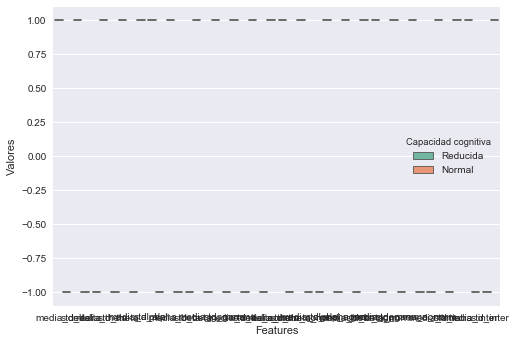

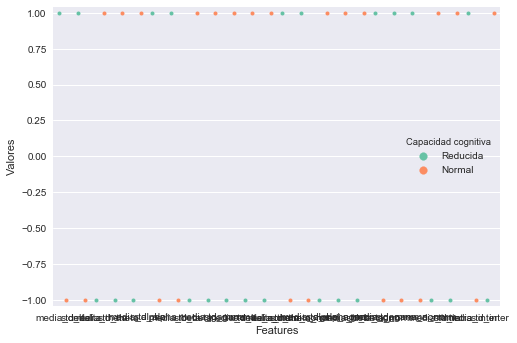

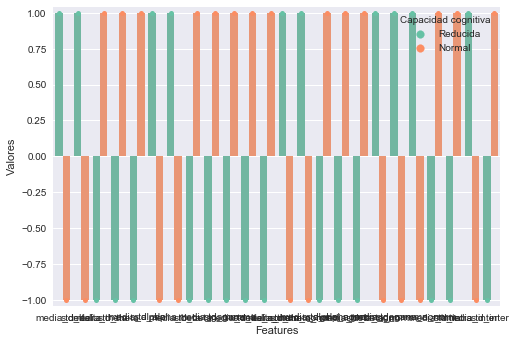

In [19]:
analisis_comparativo(df_features_normalizado_compress)

In [20]:
numpy_to_pickle(np_features_por_paciente_estandarizado, "df_features_estandarizado")

Creando index...
agrupacion_feature           media                                            \
feature                      delta         theta         alpha          beta   
tipo indice_paciente                                                           
P    0                1.640200e-11  3.212565e-12  1.062605e-12  1.094488e-12   
S    0                8.785838e-12  2.255187e-12  2.061689e-12  5.393903e-12   

agrupacion_feature                                                             \
feature                      gamma delta_norm theta_norm alpha_norm beta_norm   
tipo indice_paciente                                                            
P    0                2.441766e-13   0.638982   0.178471   0.081279  0.076343   
S    0                6.346465e-12   0.321599   0.095496   0.089780  0.226482   

agrupacion_feature                 ...              std                \
feature              gamma_norm    ...            alpha          beta   
tipo indice_paciente          